In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import torch.distributions as dist

from copy import deepcopy
from torch.utils.data import DataLoader, TensorDataset
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
train_data = np.load('train_data.npy', allow_pickle=True, encoding='latin1')
train_data.shape

(1000, 49, 2)

In [ ]:
shape_data = np.load('shape_data.npy', allow_pickle=True, encoding='latin1')
shape_data.shape

(49, 2)

In [ ]:
factor=100.0

for i in range(len(shape_data)):
    shape_data[i] = [shape_data[i][0]/factor, shape_data[i][1]/factor]

for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        train_data[i][j] = [max(1, int(train_data[i][j][0]/factor)), max(1, int(train_data[i][j][1]/factor))]

print(shape_data[0])
print(train_data[0][0])

[32 17]
[46 31]


In [ ]:
import numpy as np
import torch

def get_image(coord, shape_data, n, m):
    grid = torch.zeros(1,n, m)
    for index in range(len(coord)):
        lx, ly = coord[index]
        w, h = shape_data[index]
        for i in range(lx, min(n, lx + w)):
            for j in range(ly, min(m, ly + h)):
                grid[0][i][j] += 1
    return grid

# Assuming train_data and shape_data are defined correctly
n, m = 64, 64
train_final = [get_image(train_data[index], shape_data, n, m).numpy() for index in range(len(train_data))]

# Convert the list of numpy arrays to a single numpy array
train_final_np = np.array(train_final)

print(train_final_np.shape)

(1000, 1, 64, 64)


In [ ]:
np.save("train_final.npy", train_final)
#train_final = np.load('train_final.npy', allow_pickle=True, encoding='latin1')

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class PolicyNetworkConcat(nn.Module):
#     def __init__(self, n, m):
#         super(PolicyNetworkConcat, self).__init__()
#         # Convolutional layers
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

#         # Calculate the size of the grid after convolutional and pooling layers
#         conv_output_size = ((n - 1) // 2 // 2 + 1) * ((m - 1) // 2 // 2 + 1) * 64

#         # Fully connected layers
#         self.fc1 = nn.Linear(conv_output_size + 2, 128)  # +2 for block width and height
#         self.fc2 = nn.Linear(128, n * m)

#     def forward(self, x, block_width, block_height):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, kernel_size=2, stride=2)
#         x = F.relu(self.conv3(x))

#         # Flatten the output for the fully connected layer
#         x = x.view(x.size(0), -1)

#         # Concatenate block dimensions
#         block_dims = torch.tensor([block_width, block_height], dtype=torch.float32).view(1, -1)
#         x = torch.cat((x, block_dims), dim=1)

#         x = F.relu(self.fc1(x))
#         action_probs = self.fc2(x)
#         return F.softmax(action_probs, dim=1)


In [ ]:
class ShapePlacementEnv:
    def __init__(self, grid_size, shapes):
        """
        Initialize the environment.
        :param grid_size: Tuple (n, m) representing the size of the grid.
        :param shapes: List of tuples representing the shapes to be placed.
        """
        self.grid_size = grid_size
        self.shapes = shapes
        self.reset()

    def reset(self):
        """
        Reset the environment for a new episode.
        :return: The initial state of the environment.
        """
        self.grid = np.zeros(self.grid_size)
        self.current_shape_index = 0
        return self.grid

    def step(self, action):
        """
        Take an action in the environment.
        :param action: Tuple (x, y) representing where to place the current shape.
        :return: (next_state, reward, done)
        """
        reward = 0
        done = False

        shape = self.shapes[self.current_shape_index]
#         if self._can_place_shape(action, shape):
#             self._place_shape(action, shape)
#             reward = 1  # Example reward for successful placement
#         else:
#             reward = -1  # Example penalty for unsuccessful placement

        self._place_shape(action, shape)

        self.current_shape_index += 1
        if self.current_shape_index >= len(self.shapes):
            done = True  # End of episode

        return self.grid, done

    def _can_place_shape(self, position, shape):
        """
        Check if a shape can be placed at the given position.
        """
        x, y = position
        shape_width, shape_height = shape
        if x + shape_width > self.grid_size[0] or y + shape_height > self.grid_size[1]:
            return False

        # Check for overlap
        for i in range(x, x + shape_width):
            for j in range(y, y + shape_height):
                if self.grid[i, j] == 1:
                    return False

        return True

    def _place_shape(self, position, shape):
        """
        Place a shape on the grid at the given position.
        """
        x, y = position
        shape_width, shape_height = shape
        for i in range(x, min(self.grid_size[0], x + shape_width)):
            for j in range(y, min(self.grid_size[1], y + shape_height)):
                self.grid[i, j] += 1

In [ ]:
class CNNDiscriminator(nn.Module):
    def __init__(self, n, m):
        super(CNNDiscriminator, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Assuming grayscale images
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the flattened output after convolutional layers
        # Assuming two 2x2 max pooling layers (you can adjust as needed)
        conv_output_size = ((n - 1) // 2 // 2 + 1) * ((m - 1) // 2 // 2 + 1) * 64

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 128)
        self.fc2 = nn.Linear(128, 1)  # Output a single value for real/fake classification

    def forward(self, x):
        # Convolutional layers with ReLU activations and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation for the first layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation, as it's a real/fake binary classification

        return torch.sigmoid(x)  # Sigmoid activation to output a probability

# Example usage
n, m = 64, 64  # Replace with your image dimensions
discriminator = CNNDiscriminator(n, m)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, n, m):
        super(PolicyNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the grid after convolutional and pooling layers
        conv_output_size = ((n - 1) // 2 // 2 + 1) * ((m - 1) // 2 // 2 + 1) * 64

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size + 2, 128)  # +2 for block width and height
        self.fc2 = nn.Linear(128, n * m)

    def forward(self, x, block_width, block_height):
        # Convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))

        # Flatten the convolutional layer output
        x = x.view(x.size(0), -1)


        # Retrieve the device from x
        device = x.device

        # Create block_dims tensor and move it to the same device as x
        # block_dims = torch.tensor([block_width, block_height], dtype=torch.float32).view(1, -1)
        block_dims = torch.tensor([block_width, block_height], dtype=torch.float32, device=device).view(1, -1)

        # Concatenate block dimensions
        x = torch.cat((x, block_dims), dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Output layer with softmax for probability distribution
        return F.softmax(x.view(-1, n, m), dim=1)  # Reshape to n x m grid

In [ ]:
n, m = 64, 64  # Example grid size
policy_net = PolicyNetwork(n, m)

In [ ]:
# Dummy data for demonstration
batch_size = 1  # Example batch size
channels = 1    # Number of channels in the image, 1 for grayscale
dummy_image = torch.randn(batch_size, channels, n, m)  # Random image
dummy_block_width = torch.tensor([5])  # Example block width
dummy_block_height = torch.tensor([5])  # Example block height

In [ ]:
# Ensure the network is in evaluation mode
#policy_net.eval()

# Forward pass to get the output probabilities
with torch.no_grad():  # Disable gradient calculations for inference
    output_probabilities = policy_net(dummy_image, dummy_block_width, dummy_block_height)
    print(output_probabilities.shape)
    probabilities = output_probabilities.squeeze()  # Remove batch dimension if batch_size is 1
    probabilities = output_probabilities.view(-1)
    categorical = dist.Categorical(probs=probabilities)

    # Sample an action from the distribution
    sampled_index = categorical.sample().item()
    row = sampled_index // m
    col = sampled_index % m
    print(f"Sampled action: {sampled_index}")
    print(row, col)

torch.Size([1, 64, 64])
Sampled action: 2886
45 6


In [ ]:
def get_coords(probabilities, n, m):
    probabilities = probabilities.squeeze()  # Remove batch dimension if batch_size is 1
    probabilities = probabilities.view(-1)
    categorical = dist.Categorical(probs=probabilities)
    #categorical = dist.Bernoulli(probs=output_probabilities)

    # Sample an action from the distribution
    sampled_index = categorical.sample().item()
    row = sampled_index // m
    col = sampled_index % m
#     print(f"Sampled action: {sampled_index}")
    return [row, col]

In [ ]:
import torch
from copy import deepcopy

def get_reward(grid_state, policy, envir, discriminator):
    if envir.current_shape_index >= len(shape_data):
        return 1

    done = False
    env = deepcopy(envir)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while not done:
        shape_index = env.current_shape_index
        width, height = shape_data[shape_index]
        width, height = torch.tensor([width], dtype=torch.float, device=device), torch.tensor([height], dtype=torch.float, device=device)

        state = env.grid
        state = torch.from_numpy(state).float().to(device)

        # Since 'state' is already a tensor, no need to re-wrap it
        # Add additional dimensions to make it 1 x 1 x n x m
        state = state.unsqueeze(0).unsqueeze(0)

        probs = policy(state, width, height)
        action = get_coords(probs, n, m)  # Define get_coords() according to your implementation

        next_state, done = env.step(action)

    final_state = torch.tensor(env.grid, dtype=torch.float, device=device)
    final_state = final_state.unsqueeze(0).unsqueeze(0)
    # reward1 = sum([x for x in final_state.flatten() if x!=1]).detach().item()

    flattened_state = final_state.flatten()
    #reward = flattened_state[flattened_state != 1].sum().item()
    reward = (flattened_state ** 2).sum().item()
    #print('reward', reward, reward1)
    #reward = discriminator(final_state).detach().item()

    return reward

In [ ]:
# def run():

#     # Plot duration curve:
#     # From http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#     episode_durations = []
#     def plot_durations():
#         plt.figure(2)
#         plt.clf()
#         durations_t = torch.FloatTensor(episode_durations)
#         plt.title('Training...')
#         plt.xlabel('Episode')
#         plt.ylabel('Duration')
#         plt.plot(durations_t.numpy())
#         # Take 100 episode averages and plot them too
#         if len(durations_t) >= 100:
#             means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#             means = torch.cat((torch.zeros(99), means))
#             plt.plot(means.numpy())

#         plt.pause(0.001)  # pause a bit so that plots are updated

#     # Parameters
#     num_episode = 512
#     batch_size = 5
#     learning_rate = 0.01
#     gamma = 0.99

#     n,m = 64,64
#     env = ShapePlacementEnv((n,m), shape_data)
#     policy_net = PolicyNetwork(n,m)
#     discriminatir = CNNDiscriminator(n,m)
#     criterion = nn.BCELoss()

#     p_optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)
#     d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)


#     # Batch History
#     state_pool = []
#     action_pool = []
#     reward_pool = []
#     block_width = []
#     block_height = []
#     steps = 0
#     factor = 1
#     for e in range(num_episode):
#         print('epoch', e)
#         state = env.reset()
#         state = torch.from_numpy(state).float()
#         state = Variable(state)
#         #env.render(mode='rgb_array')

#         for t in count():

#             shape_index = env.current_shape_index
#             width, height = shape_data[shape_index]
#             width, height = torch.tensor([width/factor]), torch.tensor([height/factor])
#             state = torch.tensor(state)

#             # Add an additional dimension to make it 1 x n x m
#             state = state.unsqueeze(0)

#             # Add an additional dimension to make it 1 x 1 x n x m
#             state = state.unsqueeze(0)

#             probs = policy_net(state, width, height)
#             action = get_coords(probs, n, m)

#             next_state, done = env.step(action)
#             reward = get_reward(next_state, policy_net, env)
#             #env.render(mode='rgb_array')

#             # To mark boundarys between episodes
#             if done:
#                 reward = 0

#             state_pool.append(state)
#             action_pool.append(action)
#             reward_pool.append(reward)
#             block_width.append(width)
#             block_height.append(height)

#             state = next_state
#             state = torch.from_numpy(state).float()
#             state = Variable(state)

#             steps += 1

#             if done:
#                 episode_durations.append(t + 1)

#                 if e%20==0:
#                     plot_durations()
#                 break

#         # Update policy
#         if e > 0 and e % batch_size == 0:
# #             print('reward pool', len(reward_pool))
# #             print('action pool', len(action_pool))
# #             print('state_pool', len(state_pool))
# #             print('steps', steps)
#             # Discount reward
#             running_add = 0
#             for i in reversed(range(steps)):
#                 if reward_pool[i] == 0:
#                     running_add = 0
#                 else:
#                     running_add = running_add * gamma + reward_pool[i]
#                     reward_pool[i] = running_add

#             # Normalize reward
#             reward_mean = np.mean(reward_pool)
#             reward_std = np.std(reward_pool)
#             for i in range(steps):
#                 reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

#             # Gradient Desent
#             p_optimizer.zero_grad()

#             for i in range(steps):
#                 state = state_pool[i]  # state is [1, 1, 64, 64]

#                 # Convert action from 2D coordinates to a single index
#                 action_2d = action_pool[i]  # action is [[row, col]]
# #                 print('action2d', action_2d)
#                 action_index = int(action_2d[0]*m + action_2d[1])  # Convert to single index
#                 action = torch.tensor([action_index], dtype=torch.int64)

#                 reward = reward_pool[i]

#                 probs = policy_net(state, block_width[i], block_height[i])
#                 # Ensure probs is of shape [1, num_actions], num_actions should be 64*64 for a 64x64 grid

#                 # Create a categorical distribution and calculate loss
#                 val = dist.Categorical(probs.view(-1))  # Flatten probs if necessary
#                 loss = -val.log_prob(action) * reward  # Negative score function x reward
#                 loss.backward()

#             p_optimizer.step()

#             ## Train Discriminator
#             k = len(state_pool)  # Number of tensors
#             print('k: ',k)
#             # Train with real Data
#             real_data = random.sample(list(train_final), k)
#             real_data = torch.stack([t for t in real_data], dim=0)
# #             print('real_data.shape', real_data.shape)

#             d_optimizer.zero_grad()
#             real_labels = torch.ones(real_data.size(0), 1)  # Labels for real images
#             outputs = discriminator(real_data)
#             real_loss = criterion(outputs, real_labels)
#             real_loss.backward()

#             # Train with fake data

#             # fake_data
#             fake_data = torch.stack([t.squeeze(0) for t in state_pool], dim=0)
# #             print('fake_data.shape',fake_data.shape)

#             fake_labels = torch.zeros(fake_data.size(0), 1)  # Labels for fake images
#             outputs = discriminator(fake_data)
#             fake_loss = criterion(outputs, fake_labels)
#             fake_loss.backward()

#             # Update discriminator weights
#             d_optimizer.step()


#             # Reset every array and list
#             state_pool = []
#             action_pool = []
#             reward_pool = []
#             block_width = []
#             block_height = []
#             steps = 0

#     return policy_net

In [ ]:
def plot_losses(generator_losses, discriminator_losses):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(generator_losses, label="Generator")
    plt.plot(discriminator_losses, label="Discriminator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def run():
    # Parameters and environment setup
    num_episode = 2000
    batch_size = 4
    learning_rate = 0.01
    gamma = 0.99
    n, m = 64, 64
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('device', device)
    env = ShapePlacementEnv((n, m), shape_data)
    policy_net = PolicyNetwork(n, m).to(device)
    discriminator = CNNDiscriminator(n, m).to(device)
    criterion = nn.BCELoss()

    p_optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    generator_losses = []
    discriminator_losses = []

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    block_width = []
    block_height = []
    steps = 0
    factor = 1

    for e in range(num_episode):
        print('epoch', e)
        state = env.reset()
        state = torch.from_numpy(state).float().to(device)

        for t in count():
            shape_index = env.current_shape_index
            width, height = shape_data[shape_index]
            width, height = torch.tensor([width], dtype=torch.float, device=device), torch.tensor([height], dtype=torch.float, device=device)

            state = state.unsqueeze(0).unsqueeze(0)

            probs = policy_net(state, width, height)
            action = get_coords(probs, n, m)  # Define get_coords() to choose an action

            next_state, done = env.step(action)
            reward = -get_reward(next_state, policy_net, env, discriminator)  # Define get_reward()

            if done:
                reward = 0

            state_pool.append(state)
            action_pool.append(action)
            reward_pool.append(reward)
            block_width.append(width)
            block_height.append(height)

            state = next_state
            state = torch.from_numpy(state).float().to(device)

            if done:
                #episode_durations.append(t + 1)
                break

        if e > 0 and e % batch_size == 0:
            # Normalize reward
            running_add = 0
            for i in reversed(range(len(reward_pool))):
                if reward_pool[i] == 0:
                    running_add = 0
                else:
                    running_add = running_add * gamma + reward_pool[i]
                    reward_pool[i] = running_add

            reward_mean = np.mean(reward_pool)
            reward_std = np.std(reward_pool)
            for i in range(len(reward_pool)):
                reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

            # Policy (Generator) Update
            p_optimizer.zero_grad()
            for i in range(len(reward_pool)):
                state = state_pool[i]
                action = action_pool[i]
                action_index = int(action[0] * m + action[1])
                action = torch.tensor([action_index], dtype=torch.int64, device=device)

                probs = policy_net(state, block_width[i], block_height[i])
                val = dist.Categorical(probs.view(-1))
                loss = -val.log_prob(action) * reward_pool[i]
                loss.backward()

                generator_loss = loss.item()  # Generator loss
            p_optimizer.step()
            generator_losses.append(generator_loss)

            # Discriminator Update
            real_data_samples = random.sample(list(train_final), len(state_pool))
            real_data = torch.stack([torch.tensor(sample, dtype=torch.float).to(device) for sample in real_data_samples])


            d_optimizer.zero_grad()
            real_labels = torch.ones(real_data.size(0), 1, device=device)
            outputs = discriminator(real_data)
            real_loss = criterion(outputs, real_labels)
            real_loss.backward()

            fake_data = torch.stack([s.squeeze(0) for s in state_pool]).to(device)
            fake_labels = torch.zeros(fake_data.size(0), 1, device=device)
            outputs = discriminator(fake_data)
            fake_loss = criterion(outputs, fake_labels)
            fake_loss.backward()
            d_optimizer.step()

            discriminator_loss = real_loss.item() + fake_loss.item()
            discriminator_losses.append(discriminator_loss)

            print('generator_loss:',generator_loss, 'discriminator_loss:',discriminator_loss)
            # Reset for next batch
            state_pool = []
            action_pool = []
            reward_pool = []
            block_width = []
            block_height = []

    plot_losses(generator_losses, discriminator_losses)
    return policy_net, discriminator, generator_losses, discriminator_losses

device cuda
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
generator_loss: 14.773974418640137 discriminator_loss: 1.3832560777664185
epoch 5
epoch 6
epoch 7
epoch 8
generator_loss: 7.419057846069336 discriminator_loss: 1.352117657661438
epoch 9
epoch 10
epoch 11
epoch 12
generator_loss: 7.1685075759887695 discriminator_loss: 1.2944489121437073
epoch 13
epoch 14
epoch 15
epoch 16
generator_loss: 7.2297797203063965 discriminator_loss: 1.2380762994289398
epoch 17
epoch 18
epoch 19
epoch 20
generator_loss: 7.047736167907715 discriminator_loss: 1.2135982513427734
epoch 21
epoch 22
epoch 23
epoch 24
generator_loss: 7.631538391113281 discriminator_loss: 1.1608348786830902
epoch 25
epoch 26
epoch 27
epoch 28
generator_loss: 7.493307113647461 discriminator_loss: 1.0189565122127533
epoch 29
epoch 30
epoch 31
epoch 32
generator_loss: 7.477906703948975 discriminator_loss: 0.9405282139778137
epoch 33
epoch 34
epoch 35
epoch 36
generator_loss: 7.1830220222473145 discriminator_loss: 0.9527643322944641
epoch

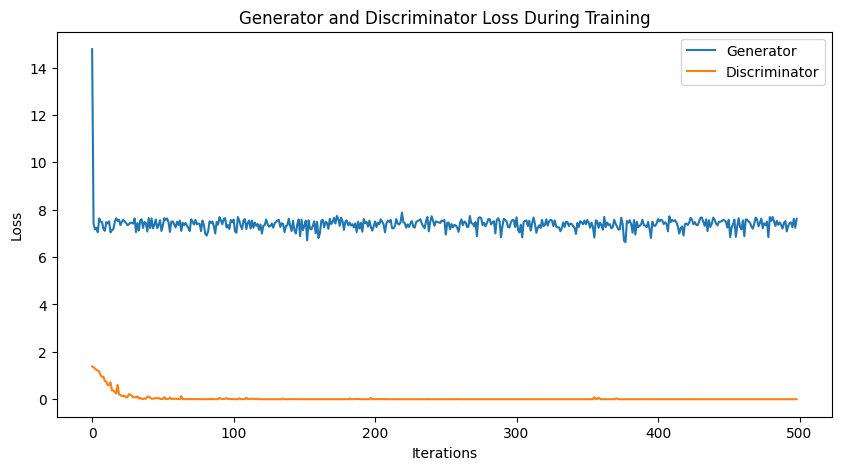

In [ ]:
policy_net, discriminator, gen_losses, disc_losses = run()

In [ ]:
gen_PATH = 'policy_net'
disc_PATH = 'disriminator'
torch.save(policy_net.state_dict(), gen_PATH)
torch.save(discriminator.state_dict(), disc_PATH)

In [ ]:
# dataset = TensorDataset(train_final)

# # Create a DataLoader
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
# print(len(dataloader))
# # Iterate over the DataLoader
# for batch in dataloader:
#     # Each 'batch' is a tuple containing a batch of data
#     data = batch[0]  # Get the data tensor from the batch
#     print(data.shape)  # This will print the shape of each batch


# import random
# real_data = random.sample(list(train_final), 10)
# real = torch.stack([t for t in real_data], dim=0)
# real.shape

In [ ]:
n, m = 64, 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use an existing policy network or create a new one
policy_net_curr = policy_net.to(device)  # Assuming policy_net is defined and is an instance of PolicyNetwork
env1 = ShapePlacementEnv((n, m), shape_data)

state = env1.reset()
state = torch.from_numpy(state).float().to(device)

curr_coords = []
steps = 0
for t in count():
    print('index', env1.current_shape_index)
    shape_index = env1.current_shape_index
    width, height = shape_data[shape_index]
    width, height = torch.tensor([width], device=device), torch.tensor([height], device=device)

    # Ensure state is a tensor on the correct device
    state = state.unsqueeze(0).unsqueeze(0)

    probs = policy_net_curr(state, width, height)
    action = get_coords(probs, n, m)
    print('action', action, 'width', width, 'height', height)
    curr_coords.append(action)

    next_state, done = env1.step(action)
    reward = get_reward(next_state, policy_net_curr, env1, discriminator)
    print(reward)

    state = torch.from_numpy(next_state).float().to(device)

    if done:
        reward = 0
        break

    steps += 1


index 0
action [54, 17] width tensor([32], device='cuda:0') height tensor([17], device='cuda:0')
3922.0
index 1
action [45, 51] width tensor([15], device='cuda:0') height tensor([6], device='cuda:0')
4530.0
index 2
action [14, 12] width tensor([21], device='cuda:0') height tensor([10], device='cuda:0')
5346.0
index 3
action [9, 61] width tensor([16], device='cuda:0') height tensor([30], device='cuda:0')
3684.0
index 4
action [0, 18] width tensor([5], device='cuda:0') height tensor([13], device='cuda:0')
4489.0
index 5
action [9, 61] width tensor([18], device='cuda:0') height tensor([8], device='cuda:0')
4738.0
index 6
action [57, 52] width tensor([8], device='cuda:0') height tensor([3], device='cuda:0')
3948.0
index 7
action [37, 35] width tensor([12], device='cuda:0') height tensor([6], device='cuda:0')
3481.0
index 8
action [56, 1] width tensor([9], device='cuda:0') height tensor([4], device='cuda:0')
3619.0
index 9
action [50, 36] width tensor([6], device='cuda:0') height tensor([2]

In [ ]:
#print(curr_coords)
print(state[43:43+32,48:48+17])
for i in range(48):
    curr_coords.append([0,0])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 2., 2., 2., 2., 2., 2., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 2., 2.],
        [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 2., 2.],
        [0., 0., 1., 2., 2., 2., 2., 2., 2., 1., 1., 0., 0., 0., 2., 2.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1

In [ ]:
# for i in range(64):
#     for j in range(64):
#         print(state[i][j].detach().item(), end=" ")
#     print("\n")

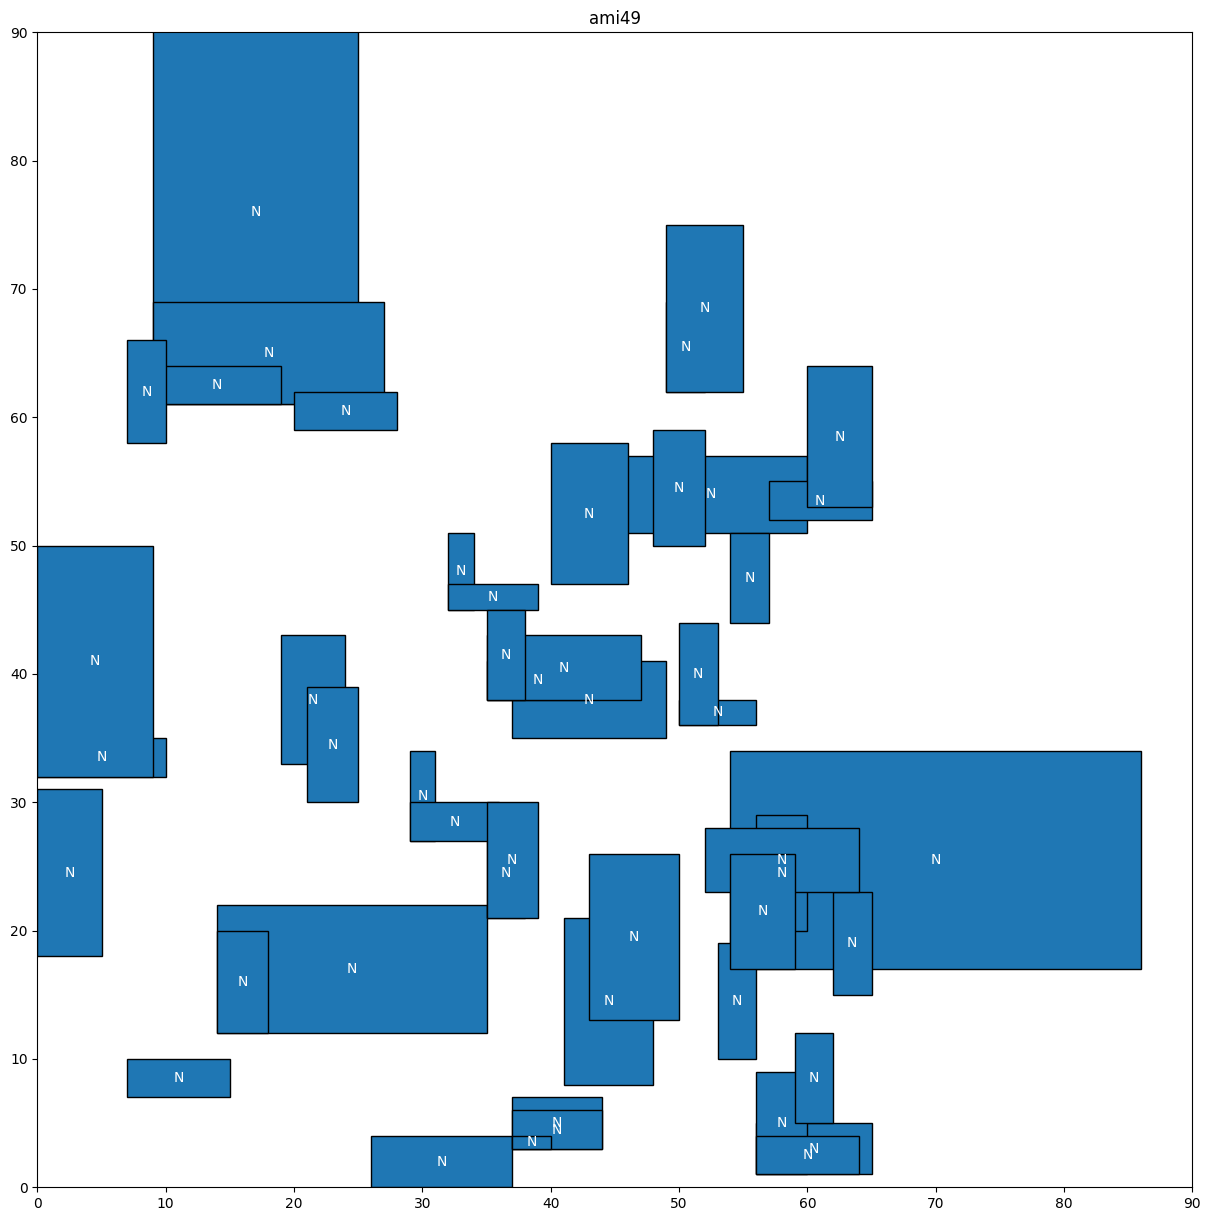

In [ ]:
def generate_images_from_files(curr_coords, shape_data):
    fig, ax = plt.subplots(figsize=(15, 15))  # Create a single subplot

    for index in range(len(shape_data)):
        x, y = curr_coords[index]
        width, height = shape_data[index]
        direction = 'N'  # Default direction

        # Adjust width and height based on the direction
        if direction in ['W', 'E', 'FE', 'FW']:
            width, height = height, width

        rect = patches.Rectangle((x, y), width, height, fill=True, edgecolor='black')
        ax.add_patch(rect)

        # Add text indicating the direction
        ax.text(x + width / 2, y + height / 2, direction, ha='center', va='center', color='white')

    # Set axis limits and properties
    ax.set_xlim(0, 90)  # Adjusted axis limits
    ax.set_ylim(0, 90)
    ax.set_aspect('equal', 'box')
    ax.set_title("ami49")

    plt.show()

# Example usage
generate_images_from_files(curr_coords, shape_data)

In [ ]:
np.save('generator_losses.npy', gen_losses)
np.save('discriminator_losses.npy', disc_losses)

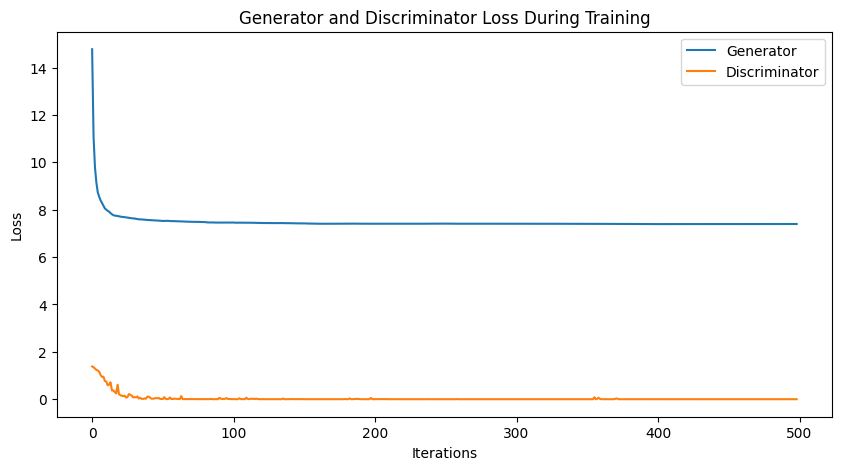

In [ ]:
gen_plt = []
disc_plt = []
run_avg_gen = 0
run_avg_disc = 0
for i in range(len(disc_losses)):
    run_avg_gen = (run_avg_gen*i+gen_losses[i])/(i+1)
    gen_plt.append(run_avg_gen)
    run_avg_disc = (run_avg_disc*i+disc_losses[i])/(i+1)
    disc_plt.append(run_avg_disc)

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_plt, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import random
comb_data = []
is_random=False

if is_random:
    for shape in shape_data:
        x,y = random.randrange(64),random.randrange(64)
        w,h = shape
        comb_data.append([w*h, x, y, w, h])
else:
    for coord,shape in zip(curr_coords, shape_data):
        x,y = coord
        w,h = shape
        comb_data.append([w*h, x, y, w, h])

print(comb_data)

# comb_data.sort(reverse=True)
coord = []
shape = []
for _, x,y,w,h in comb_data:
    coord.append([x,y])
    shape.append([w,h])


In [ ]:
n, m = 64, 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use an existing policy network or create a new one
policy_net_curr = policy_net.to(device)  # Assuming policy_net is defined and is an instance of PolicyNetwork
#policy_net_curr = PolicyNetwork(n, m).to(device)
env1 = ShapePlacementEnv((n, m), shape_data)

state = env1.reset()
state = torch.from_numpy(state).float().to(device).unsqueeze(0).unsqueeze(0)

curr_coords = []
steps = 0
for t in range(49):
    print('t',t)
    x,y = coord[t]
    width, height = shape[t]
    width, height = torch.tensor([width], device=device), torch.tensor([height], device=device)

    # Ensure state is a tensor on the correct device

    probs = policy_net_curr(state, width, height)
    action = get_coords(probs, n, m)
    print('action', action, 'width', width, 'height', height)
    curr_coords.append(action)

    next_state = state
    print(next_state.shape)
    for i in range(x,min(n,x+width[0])):
        for j in range(y, min(m,y+height[0])):
            next_state[0][0][i][j]+=1

    #state = torch.from_numpy(next_state).float().to(device)

    steps += 1


In [ ]:
generate_images_from_files(coord, shape)

In [ ]:
print(train_final[0][0][-10:,-10:])

In [ ]:
# discriminator = CNNDiscriminator(64,64).to('cuda')
# discriminator.load_state_dict(torch.load('/content/disriminator'))